This downloads the file from github

In [0]:
import requests

file_link = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'

response = requests.get(url = file_link, stream = True)
with open('housing.csv', 'wb') as f:
  for chunk in response.iter_content(chunk_size = 1024):
    f.write(chunk)


This loads the csv file into a pandas dataframe and displays the first 10 rows

In [22]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('housing.csv')
dataset = dataset.dropna()
# print(dataset.iloc[:10])
dataset.head(n=10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [24]:
columns = dataset.columns
print("The columns are : ")
for c in columns:
  print(c)

The columns are : 
longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity


This plots each feature of first 18 rows using subplots in matplotlib.

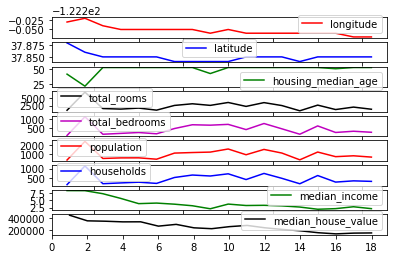

In [25]:
import matplotlib.pyplot as plt


num_columns = len(columns) -1
fig, sub_plot = plt.subplots(num_columns)

x = [i for i in range(1,19)]
i = 0 
for column in columns[:-1]:
  y = dataset[column][:18]
  sub_plot[i].plot(x, y, label = column,color="rbgkmrbgkm"[i])
  sub_plot[i].legend(loc='best')
  i+=1

plt.xticks([j*2 for j in range(10)])
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

Y = dataset['median_house_value']
X = dataset.loc[:, 'longitude' : 'median_income']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 2003)

In [0]:
x_train_np = x_train.values
y_train_np = y_train.values

x_test_np = x_test.values
y_test_np = y_test.values

In [28]:
print(x_train_np.shape)
print(x_test_np.shape)

(14303, 8)
(6130, 8)


In [0]:
import torch
from torch.nn import Conv1d, MaxPool1d, Flatten, Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD,Adamax, Adam
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score
from torch.nn import MSELoss

In [0]:
# This returns the average L1 loss and R^2 score
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric._update([predictions, output])
    score = score_metric.compute()

    if(train):
      # Clear any errors so they don't accummulate
      optimizer.zero_grad()
      # compute the gradients for our optimizer
      loss.backward()
      # use the optimizer to update the model's based in the gradients
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss / count, avg_score / count

In [0]:
from torch.nn import Sequential, Conv1d, MaxPool1d, Flatten, Linear, ReLU,Dropout,BatchNorm1d, AvgPool1d
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, input_size, output_size):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.input_size = input_size
    self.output_size = output_size

    self.model = Sequential(
        Conv1d(8, 64, 1),
        ReLU(),
        MaxPool1d(1),
        
        Conv1d(64, 128, 1),
        ReLU(),
        MaxPool1d(1),

        Flatten(),
        Linear(128, 64),
        ReLU(),

        Linear(64, output_size)
      )
  def feed(self, input):
    return self.model(input)


In [32]:
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1],1)
model.cuda()

CnnRegressor(
  (model): Sequential(
    (0): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [33]:
from torch.optim import Adam, Adagrad,RMSprop

epochs = 100
# optimizer = Adagrad(model.parameters(), lr = 1e-3)
optimizer = Adam(model.parameters(), lr = 0.002)
# optimizer = RMSprop(model.parameters(), lr = 0.03)
10031003
inputs = torch.from_numpy(x_train_np.reshape(x_train_np.shape[0], x_train_np.shape[1],1)).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)
  print("epoch {}: \n\tLoss = {}\n\tR^2 Score = {}".format(epoch+1, avg_loss, avg_r2_score))



epoch 1: 
	Loss = 126205.55727998879
	R^2 Score = -1.9685180378170637
epoch 2: 
	Loss = 83368.03762612108
	R^2 Score = -0.06378617535151608
epoch 3: 
	Loss = 78156.19137121637
	R^2 Score = 0.20856564924343396
epoch 4: 
	Loss = 75759.52597743834
	R^2 Score = 0.2645147160391431
epoch 5: 
	Loss = 73708.54738298767
	R^2 Score = 0.2879866286774255
epoch 6: 
	Loss = 71584.96155058856
	R^2 Score = 0.3210584600822285
epoch 7: 
	Loss = 68286.97409262892
	R^2 Score = 0.37151325091634624
epoch 8: 
	Loss = 66326.52510159754
	R^2 Score = 0.4053979993790625
epoch 9: 
	Loss = 64057.92888172646
	R^2 Score = 0.44389268731701503
epoch 10: 
	Loss = 63317.097901485424
	R^2 Score = 0.46137380111491205
epoch 11: 
	Loss = 61675.836427970855
	R^2 Score = 0.48532645547655207
epoch 12: 
	Loss = 60396.09919772982
	R^2 Score = 0.48794397717776017
epoch 13: 
	Loss = 59611.448062640135
	R^2 Score = 0.5055153429826216
epoch 14: 
	Loss = 58678.94359585202
	R^2 Score = 0.5312245120533801
epoch 15: 
	Loss = 57493.74719

In [34]:
inputs = torch.from_numpy(x_test_np.reshape(x_test_np.shape[0], x_test_np.shape[1], 1)).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is : ", avg_loss)
print("The model's R^2 score is: ", avg_r2_score)

The model's L1 loss is :  49164.89749177632
The model's R^2 score is:  0.646648566237782


Saving the model

In [35]:
torch.save(model, '1093805_1dconv_reg')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loading the saved model

In [0]:
saved_model = torch.load('1093805_1dconv_reg')

In [38]:
inputs = torch.from_numpy(x_test_np.reshape(x_test_np.shape[0], x_test_np.shape[1], 1)).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(saved_model, loader)
print("The model's L1 loss is : ", avg_loss)
print("The model's R^2 score is: ", avg_r2_score)

The model's L1 loss is :  49221.88865131579
The model's R^2 score is:  0.6324103303217471
